In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

 99% 245M/247M [00:01<00:00, 154MB/s]
100% 247M/247M [00:01<00:00, 154MB/s]


In [3]:
! unzip satellite-images-of-water-bodies.zip

Streaming output truncated to the last 5000 lines.
  inflating: Water Bodies Dataset/Images/water_body_1808.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1809.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1810.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1811.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1812.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1813.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1814.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1815.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1816.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1817.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1818.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1819.jpg  
  inflating: Water Bodies Dataset/Images/water_body_182.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1820.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1822.jpg  
  inf

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tqdm
import matplotlib.pyplot as plt

In [5]:
import os
import shutil

# set paths to image and mask directories
train_image_dir = '/content/Water Bodies Dataset/Images'
train_mask_dir = '/content/Water Bodies Dataset/Masks'

# create directory for validation data
val_image_dir = '/content/Water Bodies Dataset val/images'
val_mask_dir = '/content/Water Bodies Dataset val/masks'
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

# get list of image and mask file names
image_files = os.listdir(train_image_dir)
mask_files = os.listdir(train_mask_dir)

# sort file names to ensure correspondence between image and mask files
image_files.sort()
mask_files.sort()

# compute number of images to move to validation directory
val_size = int(0.2 * len(image_files))

# move images and masks to validation directory
for i in range(val_size):
    image_file = image_files.pop()
    mask_file = mask_files.pop()
    shutil.move(os.path.join(train_image_dir, image_file), os.path.join(val_image_dir, image_file))
    shutil.move(os.path.join(train_mask_dir, mask_file), os.path.join(val_mask_dir, mask_file))


In [6]:
image_dir = '/content/Water Bodies Dataset/Images'
masks_dir = '/content/Water Bodies Dataset/Masks'


In [7]:
samples = next(os.walk(image_dir))[-1][:10]
masks= next(os.walk(masks_dir))[-1][:10]

In [8]:
j = 0
dir = image_dir 
samples_ = np.zeros(shape=(len(samples),256,256, 3))
for f in range(len(samples)):
  image = tf.io.read_file(os.path.join (dir, samples[f]))
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (256, 256),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  samples_[j] = tf.cast(image, tf.float32) / 255.0
  j = j + 1

In [9]:
j = 0
dir = masks_dir 
masks_ = np.zeros(shape=(len(samples),256,256, 3))
for f in range(len(samples)):
  image = tf.io.read_file(os.path.join (dir, samples[f]))
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (256, 256),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  masks_[j] = tf.cast(image, tf.float32) / 255.0
  j = j + 1

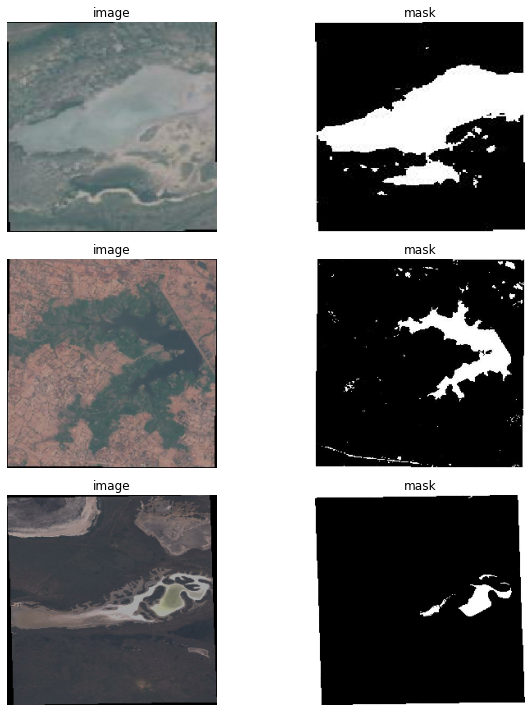

In [10]:
plt.figure(figsize=(10,10))
for i in range(1,7):
    plt.subplot(3,2,i)
    
    if i%2!=0:
        id = np.random.randint(len(samples_))
        plt.imshow(samples_[id])
        plt.title('image')
        plt.axis('off')
    elif i%2==0:
        plt.imshow(masks_[id])
        plt.title('mask')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
from keras.preprocessing.image import ImageDataGenerator
import cv2

def rgb2gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    g = np.expand_dims(gray, axis=-1)
    return g

In [108]:
import numpy as np
import cv2
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define image and mask directories


# create an ImageDataGenerator object for data augmentation with histogram equalization
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rescale=1./255)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args )

# create generator objects
batch_size = 20
seed = 1
image_generator = image_datagen.flow_from_directory('/content/Water Bodies Dataset',classes=['Images'], target_size=(224, 224), class_mode=None, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow_from_directory('/content/Water Bodies Dataset', classes=['Masks'], target_size=(224, 224), class_mode=None, batch_size=batch_size, seed=seed)
image_datagen = ImageDataGenerator(rescale=1./255)
mask_data = ImageDataGenerator()
image_generator_val = image_datagen.flow_from_directory('/content/Water Bodies Dataset val',classes=['images'], target_size=(224, 224), class_mode=None, batch_size=batch_size, seed=seed)
mask_generator_val = mask_data.flow_from_directory('/content/Water Bodies Dataset val',classes=['masks'], target_size=(224, 224), class_mode=None, batch_size=batch_size, seed=seed)
# combine generators into one which yields image and mask
def binarize_mask(mask):
    threshold = 0.5
    binary_mask = np.where(mask > 0.5, 1, 0)
    return binary_mask
mask_generator = map(binarize_mask, mask_generator)
mask_generator_val = map(binarize_mask, mask_generator_val)
train_generator = zip(image_generator, mask_generator)
val_generator = zip(image_generator_val, mask_generator_val)

# train your model using the train_generator


Found 2273 images belonging to 1 classes.
Found 2273 images belonging to 1 classes.
Found 568 images belonging to 1 classes.
Found 568 images belonging to 1 classes.


In [118]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Threshold(Layer):
    def __init__(self, threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold

    def call(self, inputs):
        return tf.keras.backend.switch(inputs > self.threshold, tf.ones_like(inputs), tf.zeros_like(inputs))

    def get_config(self):
        config = super().get_config()
        config['threshold'] = self.threshold
        return config

In [119]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [120]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

In [124]:
def unet_model(input_size=(224, 224, 3), n_filters=32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)
    # conv10 = Threshold(threshold=0.5)(conv10)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [16]:
# from tensorflow.keras import backend as K
# def iou_threshold(threshold=0.5):
#     def iou(y_true, y_pred):
#         y_pred_thresh = K.cast(y_pred > threshold, dtype='float32')
#         intersection = K.sum(K.abs(y_true * y_pred_thresh), axis=[1, 2, 3])
#         union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred_thresh, axis=[1, 2, 3]) - intersection
#         iou = K.mean((intersection + K.epsilon()) / (union + K.epsilon()))
#         return iou
#     return iou

In [84]:
# from tensorflow.keras.models import Sequential
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(UpSampling2D((2, 2)))

In [125]:
model = unet_model(n_filters=32,input_size=(224,224,3))

model.compile(optimizer='adam',loss='binary_crossentropy', 
              metrics=['accuracy'])

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

In [19]:
len(next(os.walk(image_dir))[-1])

2273

In [20]:
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
# from tensorflow.keras.optimizers import Adam

# # Load the VGG16 model pre-trained on ImageNet
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Define the encoder and decoder parts of the U-Net
# inputs = Input(shape=(224, 224, 3))
# # Encoder
# conv1 = base_model.get_layer('block1_conv2')(inputs)
# pool1 = base_model.get_layer('block1_pool')(conv1)
# conv2 = base_model.get_layer('block2_conv2')(pool1)
# pool2 = base_model.get_layer('block2_pool')(conv2)
# conv3 = base_model.get_layer('block3_conv3')(pool2)
# pool3 = base_model.get_layer('block3_pool')(conv3)
# conv4 = base_model.get_layer('block4_conv3')(pool3)
# pool4 = base_model.get_layer('block4_pool')(conv4)
# conv5 = base_model.get_layer('block5_conv3')(pool4)
# # Decoder
# up6 = UpSampling2D((2,2))(conv5)
# concat6 = concatenate([up6, conv4], axis=-1)
# conv6 = Conv2D(512, (3,3), activation='relu', padding='same')(concat6)
# conv6 = Dropout(0.2)(conv6)
# up7 = UpSampling2D((2,2))(conv6)
# concat7 = concatenate([up7, conv3], axis=-1)
# conv7 = Conv2D(256, (3,3), activation='relu', padding='same')(concat7)
# conv7 = Dropout(0.2)(conv7)
# up8 = UpSampling2D((2,2))(conv7)
# concat8 = concatenate([up8, conv2], axis=-1)
# conv8 = Conv2D(128, (3,3), activation='relu', padding='same')(concat8)
# conv8 = Dropout(0.2)(conv8)
# up9 = UpSampling2D((2,2))(conv8)
# concat9 = concatenate([up9, conv1], axis=-1)
# conv9 = Conv2D(64, (3,3), activation='relu', padding='same')(concat9)
# conv9 = Dropout(0.2)(conv9)
# outputs = Conv2D(1, (1,1), activation='sigmoid')(conv9)

# # Create the model
# model = Model(inputs=[inputs], outputs=[outputs])

# # Freeze the weights of the encoder layers
# for layer in base_model.layers:
#     layer.trainable = False

# # Compile the model
# model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [106]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
callbacks = [checkpoint]

In [126]:
history = model.fit(train_generator, validation_data = val_generator, epochs=30 ,steps_per_epoch = 142,validation_steps = 30 , callbacks=callbacks)

Epoch 1/30
142/142 [==============================] - 93s 603ms/step - loss: 0.5144 - accuracy: 0.7537 - val_loss: 0.5194 - val_accuracy: 0.7656
Epoch 2/30
142/142 [==============================] - 86s 606ms/step - loss: 0.4509 - accuracy: 0.7964 - val_loss: 0.5326 - val_accuracy: 0.7583
Epoch 3/30
142/142 [==============================] - 87s 614ms/step - loss: 0.4377 - accuracy: 0.8066 - val_loss: 0.5341 - val_accuracy: 0.7568
Epoch 4/30
142/142 [==============================] - 84s 592ms/step - loss: 0.4244 - accuracy: 0.8119 - val_loss: 0.4631 - val_accuracy: 0.7972
Epoch 5/30
142/142 [==============================] - 86s 607ms/step - loss: 0.4337 - accuracy: 0.8033 - val_loss: 0.5300 - val_accuracy: 0.7707
Epoch 6/30
142/142 [==============================] - 84s 591ms/step - loss: 0.4123 - accuracy: 0.8228 - val_loss: 0.4454 - val_accuracy: 0.8042
Epoch 7/30
142/142 [==============================] - 83s 585ms/step - loss: 0.4042 - accuracy: 0.8268 - val_loss: 0.4666 - val_ac

In [127]:
samples = next(os.walk('/content/Water Bodies Dataset val/images'))[-1][:10]

In [128]:
j = 0
dir = '/content/Water Bodies Dataset val/images'
a = np.zeros(shape=(len(samples),224,224, 3))
for f in range(len(samples)):
  image = tf.io.read_file(os.path.join (dir, samples[f]))
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (224, 224),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  a[j] = tf.cast(image, tf.float32) / 255.0
  j = j + 1

In [ ]:
a.shape

1/1 [==============================] - 0s 401ms/step


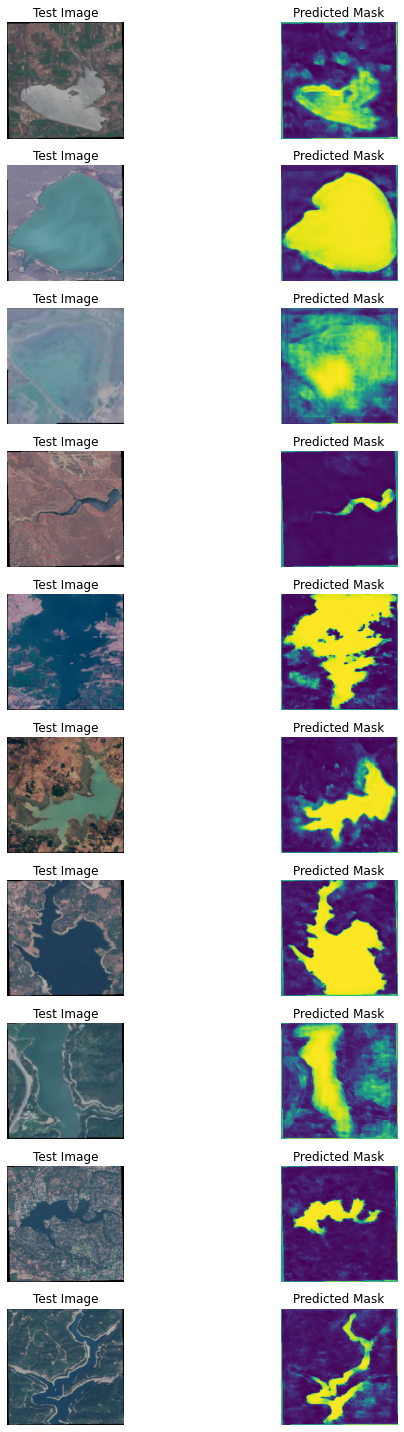

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# assume you have a list of test images and their predicted segmentation masks

predicted_masks = model.predict(a)  # a list of predicted segmentation masks

# set up the figure and axes for plotting
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))

# iterate over each test image and its predicted mask, and plot them side by side
for i, (image, mask) in enumerate(zip(a, predicted_masks)):
    # plot the test image on the left
    axes[i][0].imshow(image)
    axes[i][0].set_title("Test Image")
    axes[i][0].axis("off")
    
    # plot the predicted mask on the right
    mask = np.squeeze(mask, axis=-1)  # remove the last dimension if it's a grayscale mask
    axes[i][1].imshow(mask)
    axes[i][1].set_title("Predicted Mask")
    axes[i][1].axis("off")

# display the figure
plt.tight_layout()
plt.show()
